We have reimplemented the original paper's code in Keras with a few modifications dou to hw limitations. We have also added a learning based method for estimateing correct exposure times. 


We have switched to using RGB images instead of Bayer filters. It makes the model more general and can be applied to more images not only RAW ones.

In [2]:
EPOCHS = 80
PS = 512
HEIGHT = 1424*2
WIDTH = 2128*2
BATCHSIZE = 16 # 32 már OOM error
LEARNING_RATE = 0.0001
VAL_COUNT = 20
VAL_BEGIN = 20
TRAIN_COUNT = 250
TRAIN_BEGIN = 500

All of the important hyperparams can be see above. If we want to tweek the model we only need to chenge the numbers here.

In [3]:
#IMPORTS:
import os
import skimage.io as io
import skimage.transform as trans
import gc

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import rawpy
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from keras.layers import Lambda
import tensorflow as tf

import time

Here are all the imports.

In [4]:
trainPath = "/home/takats_balint1/deephf/data/Sony_train_list.txt"
testPath = "/home/takats_balint1/deephf/data/Sony_test_list.txt"
valPath = "/home/takats_balint1/deephf/data/Sony_val_list.txt"
replaceString = "/home/takats_balint1/deephf/data"

In [5]:
def LoadData(path):
    Data = []
    with open(path) as File:
        for line in File:
            data, truth, _, _ = line.split()
            data = data.replace(".", replaceString, 1)
            truth = truth.replace(".", replaceString, 1)
            # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
            Data.append([data, truth])
    print (len(Data))
    return Data

Path to the training data.

In [6]:
trainData = LoadData(trainPath)
valData = LoadData(valPath)
testData = LoadData(testPath)

1865
234
598


In [7]:

def unet(input_size = (None, None, 3)):
    inputs = Input(input_size)

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs) # (s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
 
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
 
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c10 = Conv2D(3, (1, 1))(c9)
    c10 = concatenate([c10, inputs])
    outputs = Conv2D(3, (3, 3), activation='sigmoid', kernel_initializer='he_normal', padding='same')(c10)
 
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model


We have modified the original UNET architecture in a few different ways. We have added batchnorm to speed up training. We have not been able to succecfuly train the model so we have not verified if it does indeed decreases convergence time. 

In [8]:
def ratio(in_path, truth_path):
    in_exposure = float(in_path[53:-5])
    #print(in_exposure)
    gt_exposure = float(truth_path[-7:-5])
    #print(gt_exposure)
    ratio = min(gt_exposure / in_exposure, 300)
    return ratio

We are hoping to replace this function with a learning based aproach. Right now we are calculating the correct expo based on metadata and not based on the images. 

In [9]:
Model = unet()
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE)
Model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = "mse", metrics = ['mae'])

In [10]:
# We load the model here
# Model = tf.keras.models.load_model('my_model')

In [11]:
import psutil
psutil.virtual_memory().percent

3.6

In [12]:
def LoadImageDataToMem(imagePaths):
    percents = [i*10 for i in range(1,11)]
    count = len(imagePaths)
    Images = {}
    index = 0
    for i in imagePaths:
        index = index + 1
        if (index / count * 100 > percents[0]):
            print(str(percents[0])+ "% of images are loaded.")
            print(str(psutil.virtual_memory().percent)+"% of memory used")
            percents.remove(percents[0])
        inputImage = i[0]
        truthImage = i[1]
    
        raw = rawpy.imread(inputImage)
        raw = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
        raw = np.float32(raw / 65535.0)
        Images[inputImage] = np.array(raw)
        if truthImage not in Images:
            gt_raw = rawpy.imread(truthImage)
            im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_image = np.float32(im / 65535.0)
            Images[truthImage] = np.array(gt_image)
    return Images

In [13]:
#trainImages = LoadImageDataToMem(trainData[0:TEST_MODE*6])
trainImages = LoadImageDataToMem(trainData[TRAIN_BEGIN:TRAIN_BEGIN+TRAIN_COUNT])

10% of images are loaded.
12.0% of memory used
20% of images are loaded.
19.2% of memory used
30% of images are loaded.
26.4% of memory used
40% of images are loaded.
33.6% of memory used
50% of images are loaded.
40.7% of memory used
60% of images are loaded.
48.2% of memory used
70% of images are loaded.
55.4% of memory used
80% of images are loaded.
62.8% of memory used
90% of images are loaded.
70.0% of memory used


In [14]:
#valImages = LoadImageDataToMem(valData[0:TEST_MODE//2])
valImages = LoadImageDataToMem(valData[VAL_BEGIN:VAL_BEGIN+ VAL_COUNT])

10% of images are loaded.
78.3% of memory used
20% of images are loaded.
78.8% of memory used
30% of images are loaded.
79.6% of memory used
40% of images are loaded.
80.1% of memory used
50% of images are loaded.
80.7% of memory used
60% of images are loaded.
81.2% of memory used
70% of images are loaded.
81.7% of memory used
80% of images are loaded.
82.3% of memory used
90% of images are loaded.
83.1% of memory used


In [15]:
# TEST_MODE should be removed when training!
def dataAugmentation(files, images,BEGIN =0, NUM = -1):
    if NUM == -1:
        NUM = len(files)
    Permutation = np.random.permutation(len(files[:NUM]))
    TRAIN = [None]*len(files[0:NUM])
    TRUTH = [None]*len(files[0:NUM])
    index = 0
    for j in Permutation:
        
        trainPath = files[j+BEGIN][0]
        truthPath = files[j+BEGIN][1]
        
        RATIO = ratio(trainPath,truthPath)
        
        xx = np.random.randint(0, WIDTH - PS)
        yy = np.random.randint(0, HEIGHT - PS)
        
        input_patch = np.array(images[trainPath][ yy:yy + PS, xx:xx + PS, :])
        gt_patch = np.array(images[truthPath][ yy:yy + PS, xx:xx + PS, :])
        
        input_patch = np.minimum(input_patch, 1.0)
        
        TRAIN[index] = input_patch*RATIO
        TRUTH[index] = gt_patch
        index = index + 1
    return np.array(TRAIN), np.array(TRUTH)

In [16]:
val_loss = []
train_loss = []  

In [17]:
Model = tf.keras.models.load_model('my_model')
from keras import backend as K
K.set_value(Model.optimizer.learning_rate, LEARNING_RATE)

In [ ]:
for epoch in range(EPOCHS):
    print("\nStart of epoch %d" % (epoch,))
    
    print(str(psutil.virtual_memory().percent)+"% of memory used")
    gc.collect()
    TRAIN, TRUTH = dataAugmentation(trainData, trainImages,TRAIN_BEGIN,TRAIN_COUNT)
    #TRAIN, TRUTH = dataAugmentation(trainData, trainImages)
    VAL_IN, VAL_OUT = dataAugmentation(valData, valImages,VAL_BEGIN,VAL_COUNT)
    #VAL_IN, VAL_OUT = dataAugmentation(valData, valImages)
        
        
        # Model.fit(input_patch, gt_patch)        
    hist = Model.fit(x=TRAIN,
              y=TRUTH,
              batch_size=BATCHSIZE,
              validation_data=(VAL_IN, VAL_OUT),
              epochs=1)
    val_loss.append(hist.history["val_loss"])
    train_loss.append(hist.history["loss"])
    if (epoch % 5 == 0):
        Model.save("my_model")
Model.save("my_model")


Start of epoch 0
82.9% of memory used
16/16 [==============================] - 110s 7s/step - loss: 0.0073 - accuracy: 0.6987 - val_loss: 0.0062 - val_accuracy: 0.8669
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model/assets

Start of epoch 1
87.1% of memory used
16/16 [==============================] - 89s 6s/step - loss: 0.0050 - accuracy: 0.7055 - val_loss: 0.0036 - val_accuracy: 0.9152

Start of epoch 2
90.3% of memory used
16/16 [==============================] - 89s 6s/step - loss: 0.0049 - accuracy: 0.6824 - val_loss: 0.0032 - val_accuracy: 0.9017

Start of epoch 3
90.4% of memory used
16/16 [==============================] - 89s 6s/step - loss: 0.0044 - accuracy: 0.6864 - val_loss: 0.0027 - val_accuracy: 0.9643

Start of epoch 4
90.4% of memory used
16/

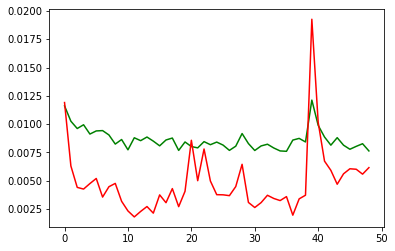

In [18]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label="train_loss", color="g")
plt.plot(val_loss, label = "val_loss", color="r")
plt.show()

In [19]:
print (train_loss)
print(val_loss)

[[0.011609094217419624], [0.010254141874611378], [0.009609118103981018], [0.009941183030605316], [0.009120972827076912], [0.009396153502166271], [0.009425945580005646], [0.009041083976626396], [0.008236237801611423], [0.008637554943561554], [0.007727667223662138], [0.008792457170784473], [0.008537632413208485], [0.008857889100909233], [0.008495659567415714], [0.008079955354332924], [0.008596767671406269], [0.008767755702137947], [0.007676109671592712], [0.00842167716473341], [0.00801851786673069], [0.007899831980466843], [0.008450311608612537], [0.008180581033229828], [0.008410829119384289], [0.008145779371261597], [0.007678748574107885], [0.008048503659665585], [0.009165775962173939], [0.008279858157038689], [0.007668263278901577], [0.008070945739746094], [0.008222615346312523], [0.007889773696660995], [0.007629482075572014], [0.007597595918923616], [0.008587630465626717], [0.008738071657717228], [0.008423575200140476], [0.012119881808757782], [0.009890907444059849], [0.00885950960218

In [11]:
Model = tf.keras.models.load_model('my_model')

With the trained model we make a prediction. We have not done any testing or validation because we have not been able to train the model fully due to hw limitations.

In [20]:
raw = rawpy.imread(testData[30][0])
print("Data loaded")
#raw = np.expand_dims(pack_raw(raw), axis=0)
raw = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)

raw = np.expand_dims(np.float32(raw / 65535.0), axis=0)
print("Data processed")
#input_patch = raw[:,0:1024,0:1024,:]
input_patch = raw*ratio(testData[30][0],testData[30][1])
#input_patch = raw


input_patch = np.minimum(input_patch, 1.0)


Data loaded
Data processed


In [21]:
print("Predicting...")
#test_out = Model.predict(input_patch[:,1300:1300+PS,1343:1343+PS,:])
test_out = Model.predict(input_patch)

print("Prediction ready")
test_out =  test_out
test_out = ((np.minimum(np.maximum(0, test_out),1)*255)).astype(int)
test_out = test_out.reshape(test_out.shape[1], test_out.shape[2], test_out.shape[3])
print(test_out)

Predicting...
Prediction ready
[[[ 80  73  73]
  [ 76  59  56]
  [ 76  61  58]
  ...
  [ 82  68  64]
  [ 87  68  64]
  [102  82  79]]

 [[ 73  58  52]
  [ 64  45  41]
  [ 60  47  44]
  ...
  [ 66  56  48]
  [ 65  54  47]
  [ 82  71  67]]

 [[ 70  58  50]
  [ 61  49  43]
  [ 57  53  49]
  ...
  [ 62  57  51]
  [ 62  54  49]
  [ 76  71  67]]

 ...

 [[ 53  39  36]
  [ 41  24  22]
  [ 38  27  26]
  ...
  [ 64  48  40]
  [ 62  46  36]
  [ 72  60  55]]

 [[ 50  41  36]
  [ 36  26  21]
  [ 38  28  26]
  ...
  [ 61  48  39]
  [ 62  47  37]
  [ 73  61  57]]

 [[ 71  60  57]
  [ 64  41  42]
  [ 59  44  46]
  ...
  [ 80  61  58]
  [ 81  62  57]
  [ 83  75  72]]]


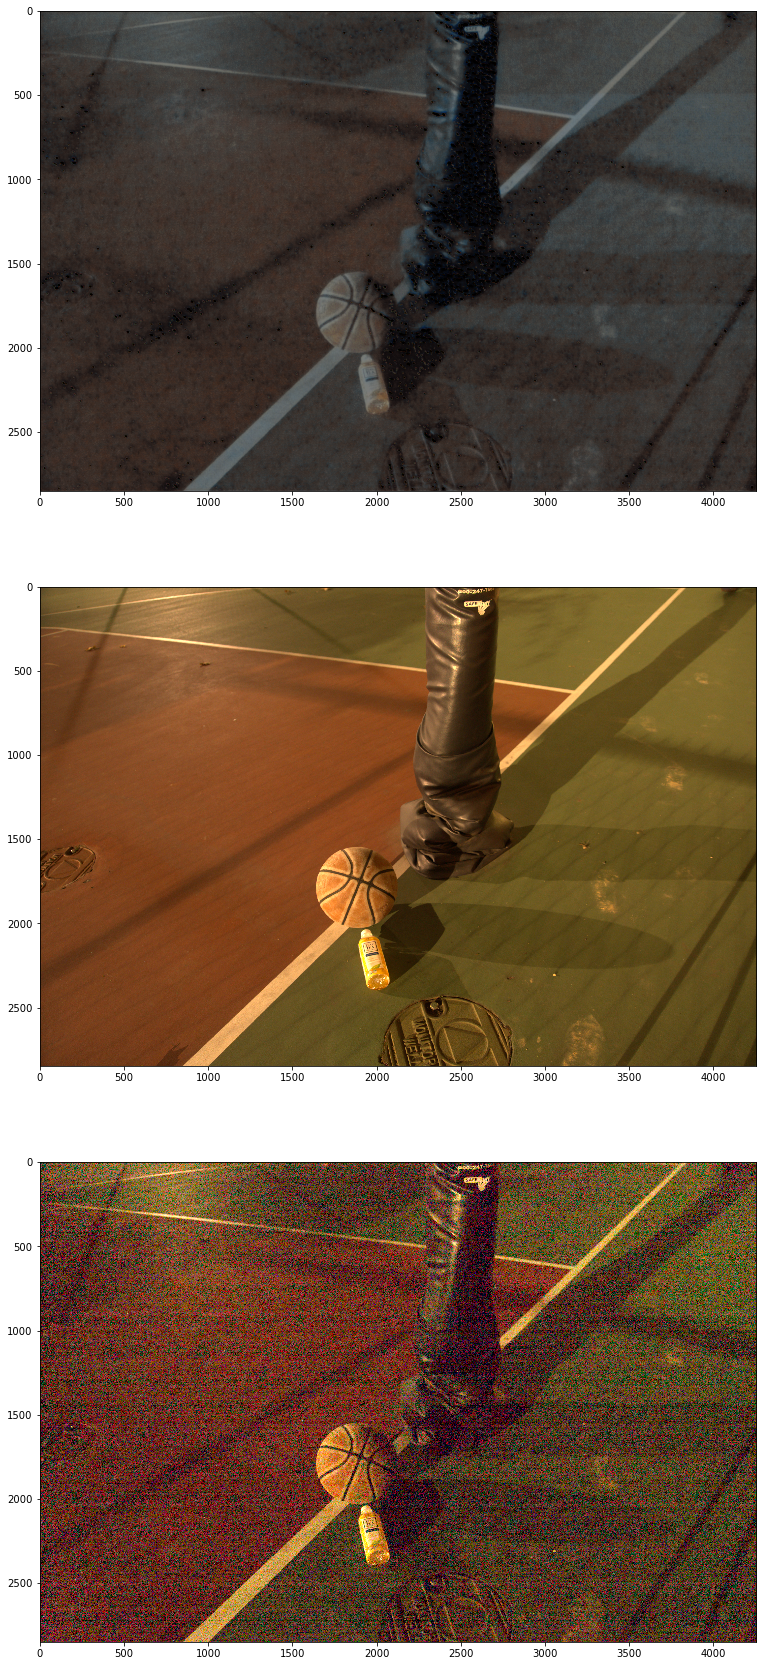

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from matplotlib import cm

test_truth = rawpy.imread(testData[30][1])
test_truth = test_truth.postprocess()

test_ori = rawpy.imread(testData[30][0])
test_ori = test_ori.postprocess()



fig, axes = plt.subplots(3,1, figsize=(30,30))
axes[0].imshow(test_out, interpolation='nearest')
axes[1].imshow(test_truth, interpolation='nearest')
axes[2].imshow(test_ori, interpolation='nearest')
plt.show()

The model produces the image seen above. It is for some reason green, we have not figured it out why. It has to do with Bayer arrays since it is an RGBG format, meaning it has 2 green channels. The rectangular artifacts may be coused by the display resolution. More training is required.